In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
            Answer:</div>

The primal problem to solve is :  

$\quad\boxed{\text{minimize} \quad (\frac{1}{2} ||\mathbf{w}||^2 + C \sum_{i=1}^n \xi _i)}$

with the constraints : 
* $y_i(w^Tx_i+w_0) \geq 1 - \xi_i \quad i=1,...,n$
* $\xi_i \geq 0 \quad i=1,...,n$

The dot product $w^Tx_i=\langle w, x_i \rangle$ can be replaced with the kernel trick. Then $\langle w, x_i \rangle$ becomes $\langle w, \phi(x_i) \rangle$ with $\phi(x_i)$ the feature map of $x$.

Then we rewrite this in terms of the hinge loss function. To do that we rewrite $\xi_i$ as $[ 1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0 ) ]_+\quad$ where $[z]_+=\text{max}(z,0)$, considering its contraints.

Then we have :  

$$ \boxed{\text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right)} $$

----

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
            Answer:</div>

> The statement "an SVM minimizes the classification error using a convex upper bound" refers to the way SVM handles the optimization problem of finding the hyperplane that separates classes while minimizing classification errors. SVM uses a hinge loss function, which is a convex function that serves as an upper bound for the 0-1 loss, making the optimization problem easier to solve.

> The pivotal loss, such as the hinge loss, is convex and smooth, providing a computationally tractable surrogate for optimization in classifiers like SVMs. It penalizes misclassifications linearly, aiming to maximize the margin while minimizing classification errors. In contrast, the loss of binary classification, represented by the 0-1 loss, is discontinuous and non-convex, directly measuring classification accuracy but posing challenges for direct optimization due to its nature.

## Example of using the SVC class from scikit-learn

In [42]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.95
Testing score : 0.85


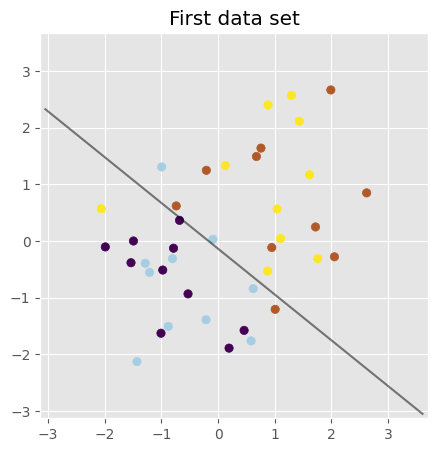

In [43]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

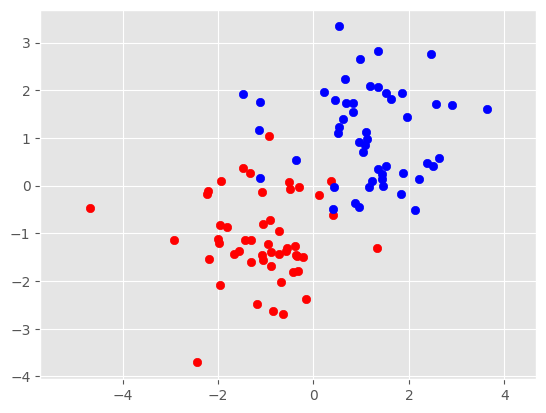

In [44]:
# Create two centers for the two distributions 
centers = [[1, 1], [-1, -1]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers, random_state=6)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

In [45]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [46]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk

# Parameters for the Gaussian distributions
mean1 = [1, 1]
mean2 = [-1, -1]
cov = [[1, 0], [0, 1]]  # covariance matrix for the Gaussian

n_mc = 10000 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):
    rand = np.random.randint(2)# Random binary choice: will the point be generated from the first or second gaussian ? 
    if rand==0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean1, cov)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean2, cov)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean1, cov)
    p2 = multivariate_normal.pdf(x, mean2, cov)

    # Compute the risk from these and add it to the total
    risk = min(p1, p2)
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.007
Estimated Bayes accuracy: 0.993


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores: 0.9625/0.95


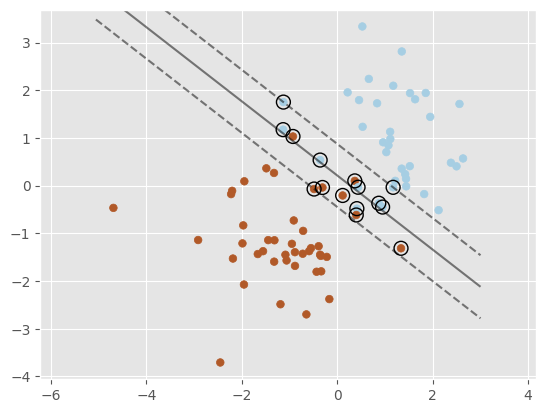

In [47]:
# Create a linear SVM and train it on the training data
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

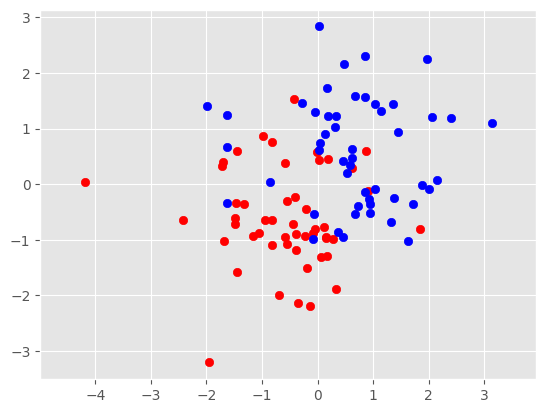

Train/Test scores: 0.825/0.85


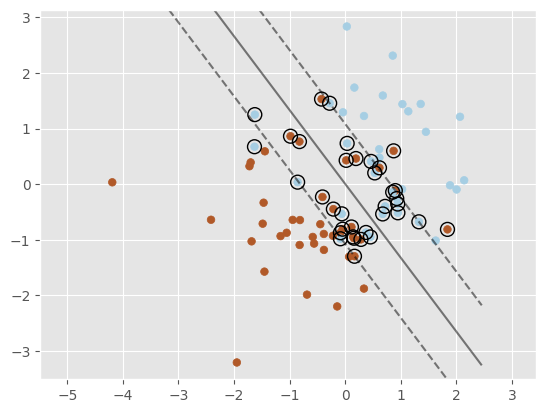

In [48]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5
# Create two centers for the two distributions 
centers = [[0.5, 0.5], [-0.5, -0.5]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=100, centers=centers, random_state=6)
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

# Create a linear SVM and train it on the training data
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

In [49]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

grid_search = GridSearchCV(clf, parameters, cv=5)
grid_search.fit(X_train, y_train)  # X_train and y_train are your training data

# Get the best parameter values
best_C = grid_search.best_params_['C']

print("Best value for C:", best_C)

Best value for C: 1.0


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

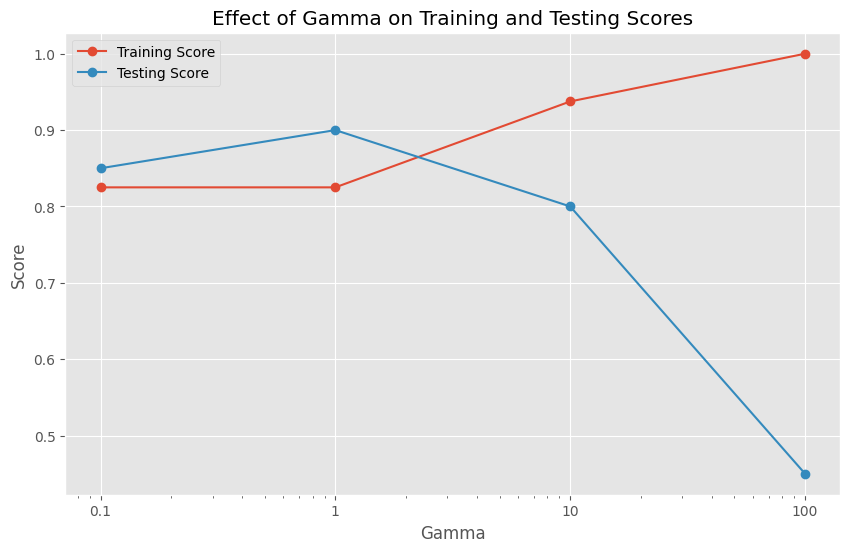

In [50]:
gammas = [0.1, 1, 10, 100]
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
train_scores = []
test_scores = []

for gamma in gammas:
    # Create SVM classifier with Gaussian kernel
    clf = SVC(kernel='rbf', gamma=gamma)
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Calculate training and testing scores
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    # Append scores to lists
    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(gammas, train_scores, marker='o', label='Training Score')
plt.plot(gammas, test_scores, marker='o', label='Testing Score')
plt.title('Effect of Gamma on Training and Testing Scores')
plt.xlabel('Gamma')
plt.ylabel('Score')
plt.xscale('log')
plt.xticks(gammas, gammas)
plt.grid(True)
plt.legend()
plt.show()

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

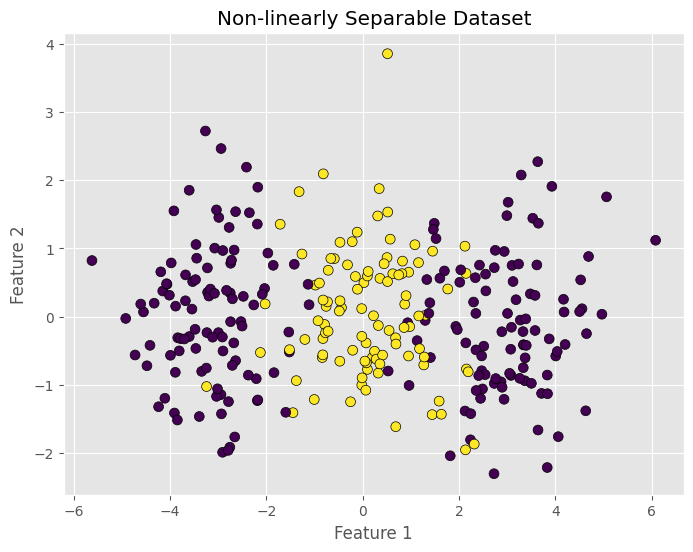

In [51]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0 

# Generate a non-linearly separable dataset
X, y = make_blobs(n_samples=300, centers=[(-3, 0), (0, 0), (3, 0)], cluster_std=1.0, random_state=42)

# Assign labels
y[y == 2] = 0  # Merge class 2 and class 0 into a single class

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolors='k')
plt.title('Non-linearly Separable Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

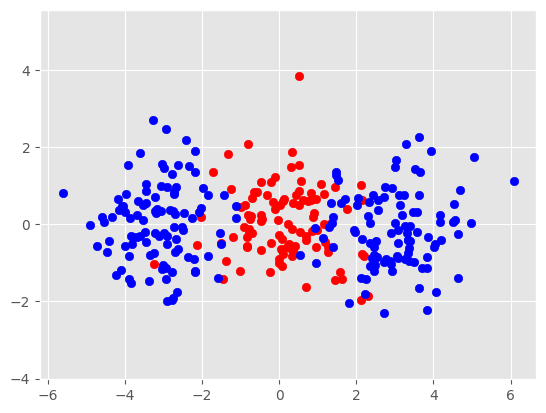

Train/Test scores: 0.6916666666666667/0.5666666666666667


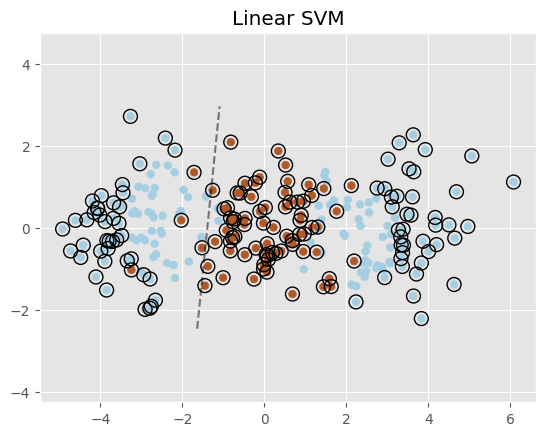

Train/Test scores: 0.9166666666666666/0.8666666666666667


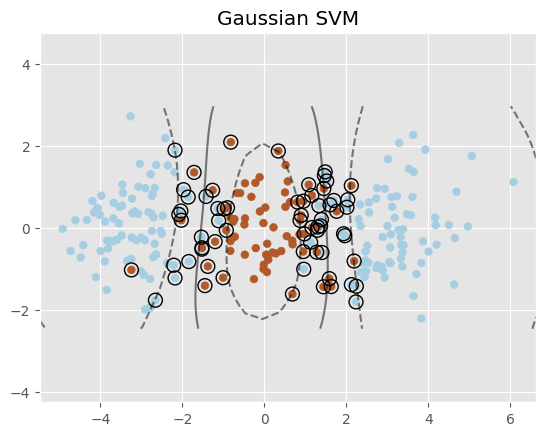

In [52]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the points 
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.axis('equal')
plt.show()

#######################################################
# Create a linear SVM and train it on the training data
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.title('Linear SVM')
plt.show()

#########################################################
# Create a gaussian SVM and train it on the training data
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.title('Gaussian SVM')
plt.show()

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

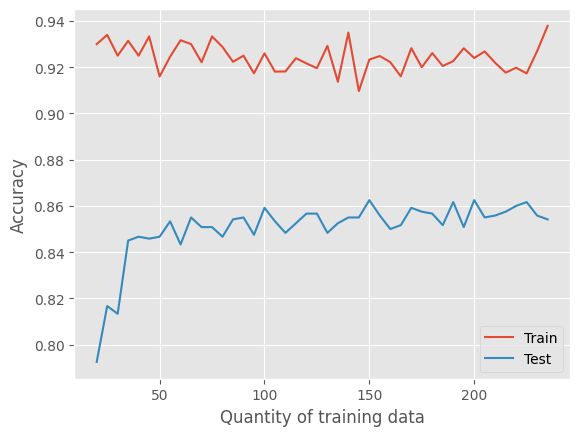

In [53]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times 
n_m = 20  

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf = SVC(kernel='rbf')
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]
        
        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)
    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [59]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4). 

# Parameters for the Gaussian distributions
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # covariance matrix for the Gaussian

n_mc = 10000 # Repeat this n_mc times - enough to approximate 
expectation = 0
for i in range(n_mc):
    rand = np.random.randint(2)# Random binary choice: will the point be generated from the first or second gaussian ? 
    if rand==0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean, cov)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean, cov)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean, cov)
    p2 = multivariate_normal.pdf(x, mean, cov)

    # Compute the risk from these and add it to the total
    risk = min(p1, p2)
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.08
Estimated Bayes accuracy: 0.92


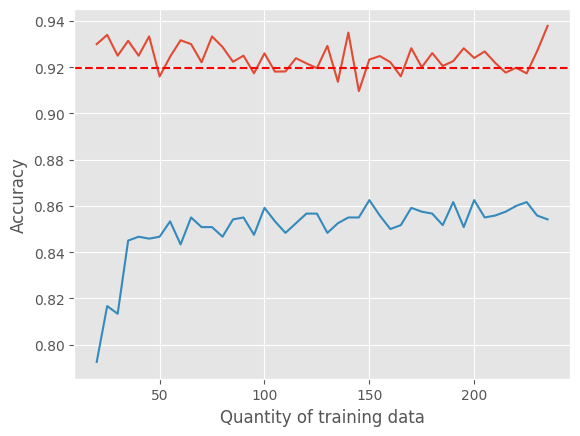

In [60]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')
plt.axhline(1 - expectation, color='r', linestyle='--', label='Bayes accuracy')

<div class='alert alert-block alert-warning'>
            Answer:</div>

> As the test accuracy is around 0.86 and the train accuracy is around 0.92, which is quite a gap, the model might suffer from an overfitting issue. We can also observe that the more we consider data points the closer the curves get. The bias accuracy is very high.

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

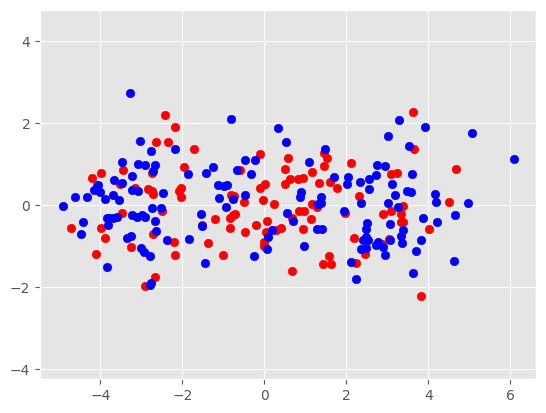

In [61]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

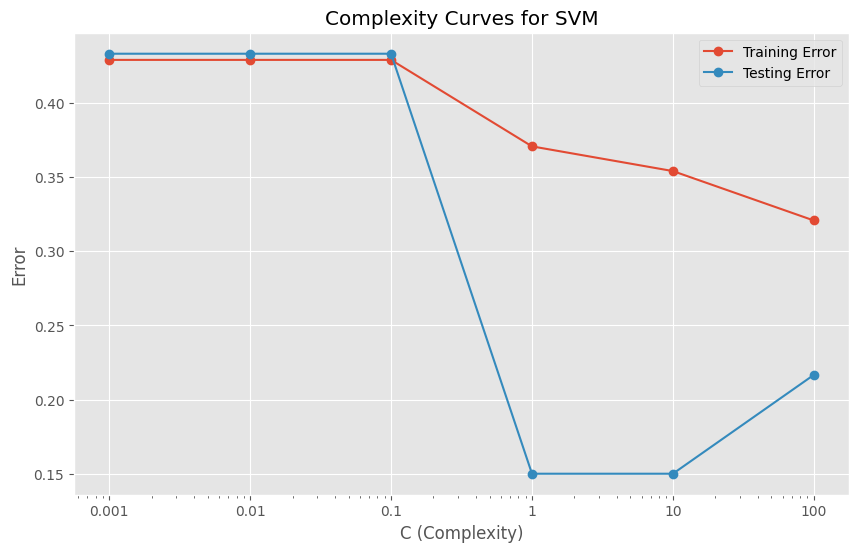

In [64]:
# Vary the hyperparameter C and plot the training/testing results

C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_errors = []
test_errors = []

for C in C_values:
    # Create and train SVM classifier
    clf = SVC(kernel='rbf', C=C)
    clf.fit(X_train, y_train)
    
    # Calculate training and testing errors
    train_error = 1 - clf.score(X_train, y_train)
    test_error = 1 - clf.score(X_test, y_test)
    
    # Append errors to lists
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot the complexity curves
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors, marker='o', label='Training Error')
plt.plot(C_values, test_errors, marker='o', label='Testing Error')
plt.title('Complexity Curves for SVM')
plt.xlabel('C (Complexity)')
plt.ylabel('Error')
plt.xscale('log')
plt.xticks(C_values, C_values)
plt.grid(True)
plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div>

> The bias is high but the variance is very low.